In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import re 
import nltk 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [40]:
df = pd.read_csv('Processed_DS.csv')
df.head()

,text,Hate,Date,Time
0,wealth if you made it through this ampamp were...,1,25-10-2023,08:21:57
1,Technically thats still turning back the clock...,1,03-03-2024,12:26:19
2,VMBJP BJP4Bengal BJP4India narendramodi JPNadd...,0,16-06-2024,11:37:38
3,krtoprakyigit Soldier of Japan Who has dick head,1,23-09-2024,06:11:52
4,blueheartedly Youd be better off asking who DO...,1,22-08-2024,07:44:17


Total Speech= 21991
Hate Speech= 14162
Non-Hate Speech= 7829


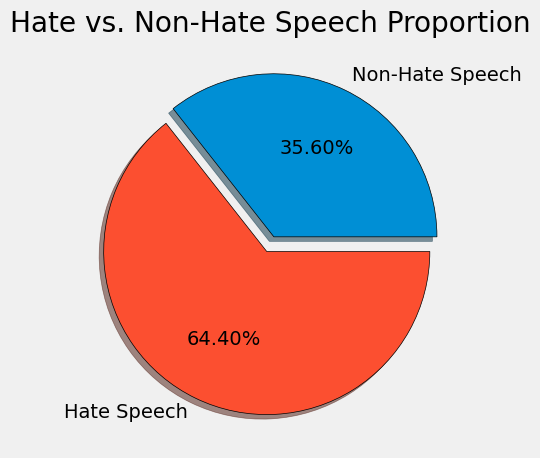

In [41]:
# Function to display toxic vs non-toxic distribution
def performDataDistribution(df):
    plt.style.use('fivethirtyeight')

    total = df.shape[0]
    num_non_toxic = df[df.Hate == 0].shape[0]
    print(f"Total Speech= {total}\nHate Speech= {total-num_non_toxic}\nNon-Hate Speech= {num_non_toxic}")
    slices = [num_non_toxic / total, (total - num_non_toxic) / total]
    labeling = ['Non-Hate Speech', 'Hate Speech']
    explode = [0.05, 0.05]
    plt.pie(slices, explode=explode, shadow=True, autopct='%1.2f%%', labels=labeling, wedgeprops={'edgecolor': 'black'})
    plt.title('Hate vs. Non-Hate Speech Proportion')
    plt.tight_layout()
    plt.show()

performDataDistribution(df)

In [42]:
def remove_pattern(input_txt,pattern):
  if(type(input_txt)==str):
    r= re.findall(pattern,input_txt)
    for i in r:
      input_txt = re.sub(i,'',input_txt)
    return input_txt
  else:
    return ""

In [43]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extract the month and add it as a new column
df['Month'] = df['Date'].dt.month

# Save the updated DataFrame to a new CSV file
df.to_csv('Processed_DS_with_month.csv', index=False)

# Display the first few rows to verify
df.head()

,text,Hate,Date,Time,Month
0,wealth if you made it through this ampamp were...,1,2023-10-25,08:21:57,10
1,Technically thats still turning back the clock...,1,2024-03-03,12:26:19,3
2,VMBJP BJP4Bengal BJP4India narendramodi JPNadd...,0,2024-06-16,11:37:38,6
3,krtoprakyigit Soldier of Japan Who has dick head,1,2024-09-23,06:11:52,9
4,blueheartedly Youd be better off asking who DO...,1,2024-08-22,07:44:17,8


In [44]:
def categorize_time(time_str):
    hour = int(time_str.split(':')[0])
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'noon'
    else:
        return 'night'

In [45]:
def perform_data_set_cleaning(df):
    df['text'].dtype
    df['lenText'] = df['text'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)

    # removes @user
    combined_df['CleanedText'] = np.vectorize(remove_pattern)(combined_df['text'], "@[\w]*")
    # removes extra letters 
    combined_df['CleanedText'] = combined_df['CleanedText'].str.replace("[^a-zA-Z#]", " ", regex=True)

    # calculate length of headline after cleaning
    combined_df['lenCleanedText'] = combined_df['CleanedText'].str.len()

    # removes short words
    combined_df['CleanedText'] = combined_df['CleanedText'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

    

    # Applied Tokenization
    tokenized_tweet = combined_df['CleanedText'].apply(lambda x: x.split())  # creates a list

    # Applied Lemmatization 
    nltk.download('wordnet')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['CleanedText'] = tokenized_tweet

    # Categorize Time into morning, noon, night
    combined_df['TimeCategory'] = combined_df['Time'].apply(categorize_time)

    return combined_df, df

combined_df, df = perform_data_set_cleaning(df)
combined_df.head()


<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\w'
C:\Users\MIHIR_KOSREKAR\AppData\Local\Temp\ipykernel_14796\1991393862.py:7: SyntaxWarning: invalid escape sequence '\w'
  combined_df['CleanedText'] = np.vectorize(remove_pattern)(combined_df['text'], "@[\w]*")
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MIHIR_KOSREKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,Hate,Date,Time,Month,lenText,CleanedText,lenCleanedText,TimeCategory
0,wealth if you made it through this ampamp were...,1,2023-10-25,08:21:57,10,204,wealth made through this ampamp were only able...,204,morning
1,Technically thats still turning back the clock...,1,2024-03-03,12:26:19,3,75,Technically thats still turning back clock dic...,75,noon
2,VMBJP BJP4Bengal BJP4India narendramodi JPNadd...,0,2024-06-16,11:37:38,6,318,VMBJP Bengal India narendramodi JPNadda AmitSh...,318,morning
3,krtoprakyigit Soldier of Japan Who has dick head,1,2024-09-23,06:11:52,9,48,krtoprakyigit Soldier Japan dick head,48,morning
4,blueheartedly Youd be better off asking who DO...,1,2024-08-22,07:44:17,8,82,blueheartedly Youd better asking DOESNT think ...,82,morning


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MIHIR_KOSREKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


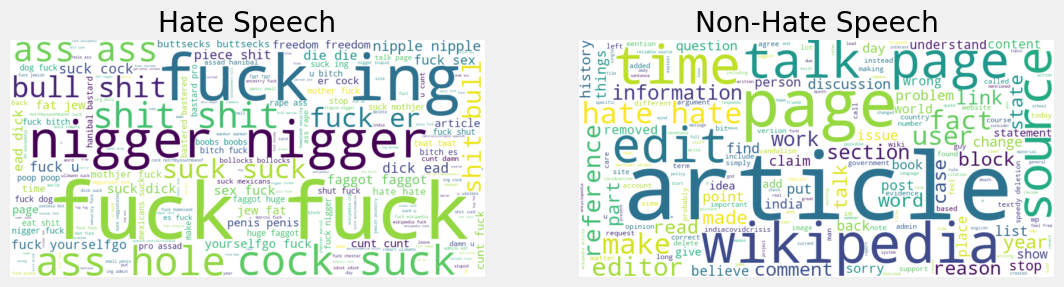

In [46]:
# Remove irrelevant characters and convert text to lowercase
combined_df['text'] = combined_df['text'].astype(str).str.replace('[^a-zA-Z0-9 ]', '', regex=True).str.lower()

# Load stopwords from file
with open('stopwords.txt', 'r') as f:
    stop_words = set(f.read().splitlines())
stop_words = list(stop_words)  # Convert set to list

# Tokenize the text
nltk.download('punkt')
combined_df['text'] = combined_df['text'].apply(lambda x: word_tokenize(x))

# Remove stop words
combined_df['text'] = combined_df['text'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

# Split data into hate and non-hate categories
hate_text = ' '.join(combined_df[combined_df['Hate'] == 1]['text'])
non_hate_text = ' '.join(combined_df[combined_df['Hate'] == 0]['text'])

# Generate word clouds with font path
wc_hate = WordCloud(width=800, height=400, background_color='white').generate(hate_text)
wc_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_text)

# Display word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_hate, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Speech')

plt.subplot(1, 2, 2)
plt.imshow(wc_non_hate, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Hate Speech')

plt.show()

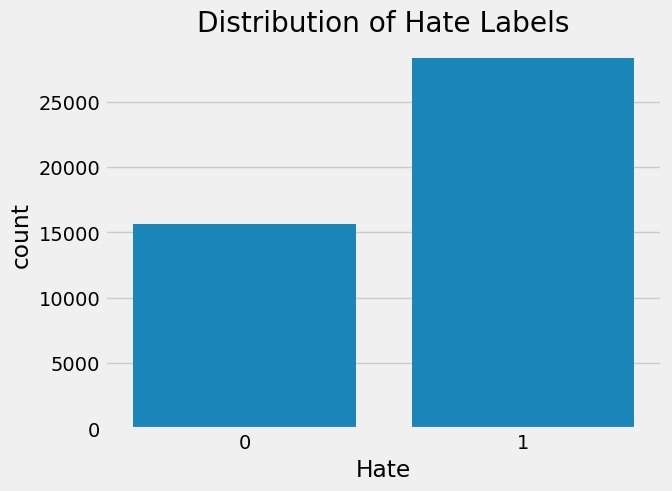

In [47]:
sns.countplot(x='Hate', data=combined_df)
plt.title('Distribution of Hate Labels')
plt.show()

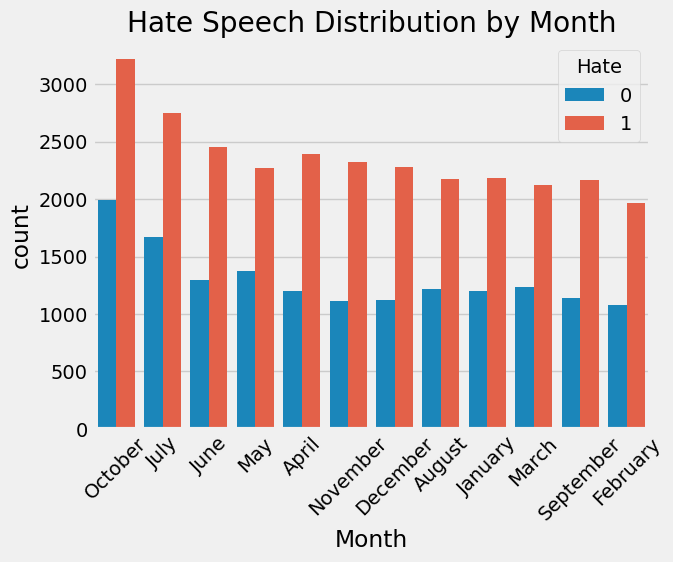

In [48]:
combined_df['Month'] = combined_df['Date'].dt.month_name()  # Month names for better readability
sns.countplot(x='Month', hue='Hate', data=combined_df, order= combined_df['Month'].value_counts().index.tolist())
plt.title('Hate Speech Distribution by Month')
plt.xticks(rotation=45)
plt.show()

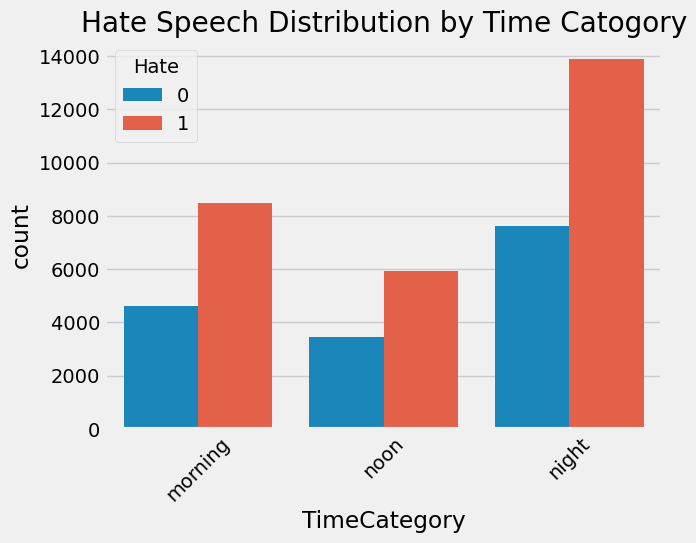

In [49]:
sns.countplot(x='TimeCategory', hue='Hate', data=combined_df)
plt.title('Hate Speech Distribution by Time Catogory')
plt.xticks(rotation=45)
plt.show()

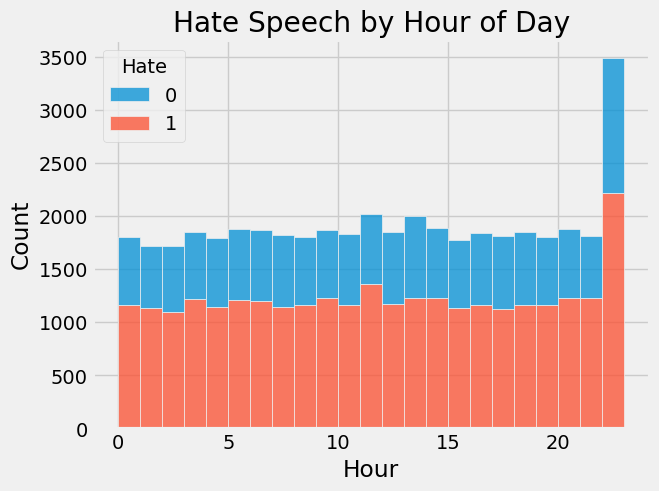

In [50]:
combined_df['Hour'] = pd.to_datetime(combined_df['Time'], format='%H:%M:%S').dt.hour
sns.histplot(data=combined_df, x='Hour', hue='Hate', multiple='stack', binwidth=1)
plt.title('Hate Speech by Hour of Day')
plt.xlabel('Hour')
plt.show()

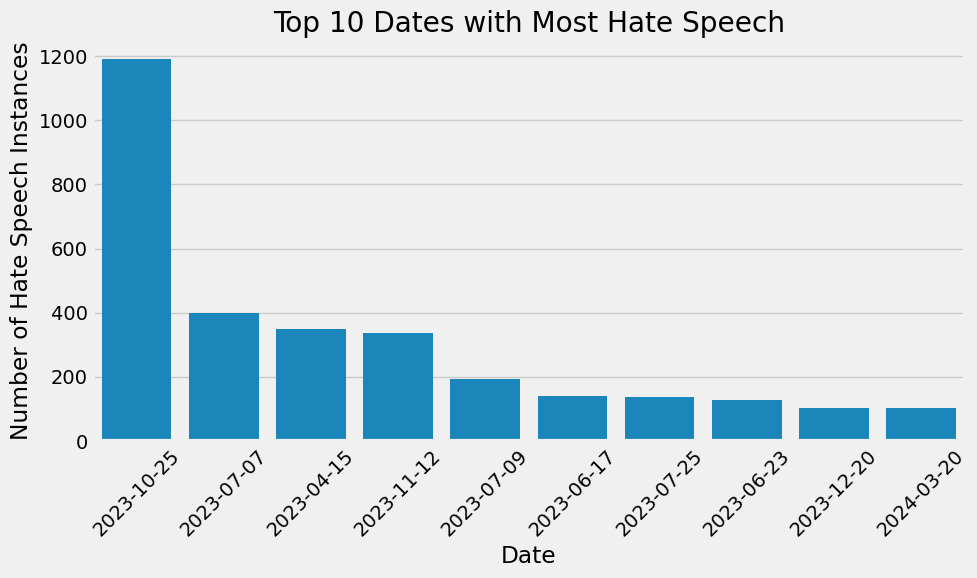

In [51]:
# Filter hate speech (Hate == 1)
hate_speech_combined_df =combined_df[combined_df['Hate'] == 1]

# Group by Date and count the occurrences of hate speech
hate_by_date = hate_speech_combined_df.groupby('Date').size().reset_index(name='HateCount')

# Sort the dates by the number of hate speech occurrences and select the top 10
top_10_hate_dates = hate_by_date.sort_values(by='HateCount', ascending=False).head(10)

# Plot the top 10 dates
plt.figure(figsize=(10, 6))
sns.barplot(x='Date', y='HateCount', data=top_10_hate_dates)
plt.title('Top 10 Dates with Most Hate Speech')
plt.xlabel('Date')
plt.ylabel('Number of Hate Speech Instances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

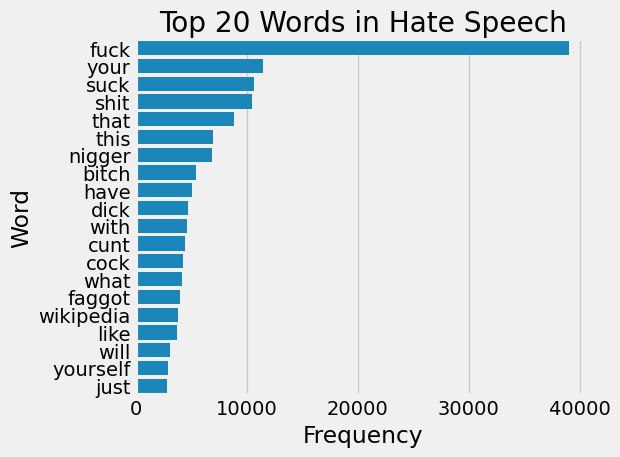

In [52]:
hate_words = ' '.join(combined_df[combined_df['Hate'] == 1]['CleanedText']).split()
non_hate_words = ' '.join(combined_df[combined_df['Hate'] == 0]['CleanedText']).split()

hate_freq = pd.DataFrame(Counter(hate_words).most_common(20), columns=['Word', 'Frequency'])
non_hate_freq = pd.DataFrame(Counter(non_hate_words).most_common(20), columns=['Word', 'Frequency'])

sns.barplot(x='Frequency', y='Word', data=hate_freq)
plt.title('Top 20 Words in Hate Speech')
plt.tight_layout()
plt.show()

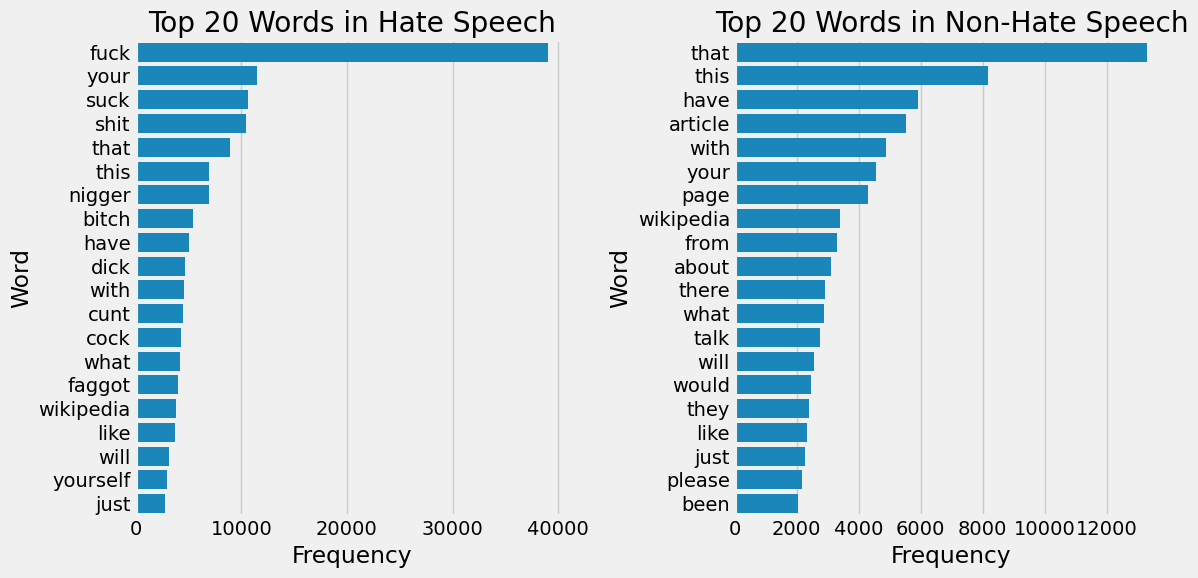

In [53]:
hate_words = ' '.join(combined_df[combined_df['Hate'] == 1]['CleanedText']).split()
non_hate_words = ' '.join(combined_df[combined_df['Hate'] == 0]['CleanedText']).split()

hate_freq = pd.DataFrame(Counter(hate_words).most_common(20), columns=['Word', 'Frequency'])
non_hate_freq = pd.DataFrame(Counter(non_hate_words).most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=hate_freq)
plt.title('Top 20 Words in Hate Speech')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=non_hate_freq)
plt.title('Top 20 Words in Non-Hate Speech')

plt.tight_layout()
plt.show()

c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


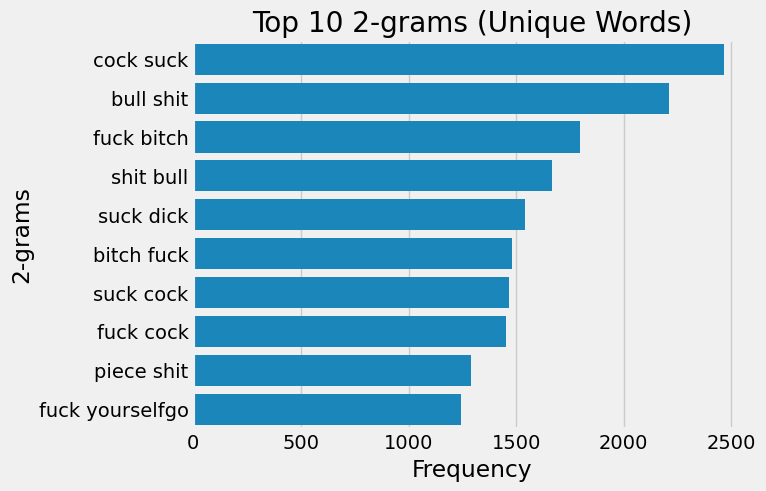

c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


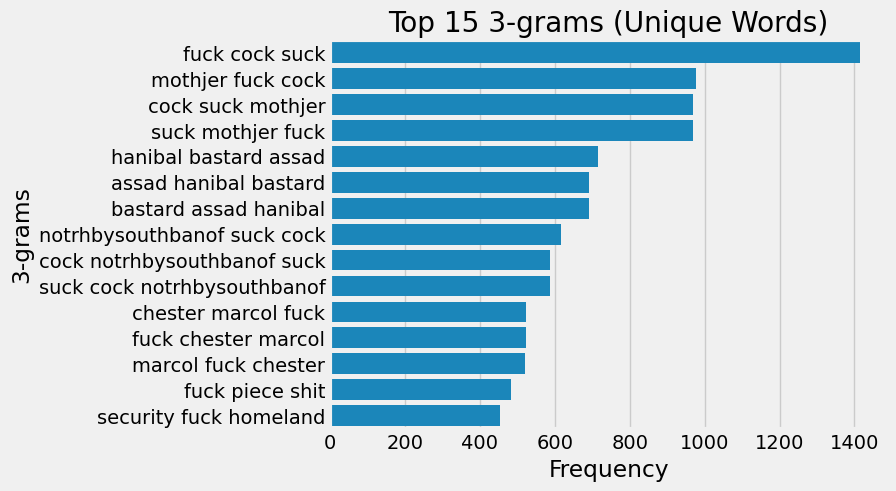

In [54]:
def filter_unique_words(ngram):
    words = ngram.split()
    return len(set(words)) == len(words)

def plot_top_ngrams(text, n, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    ngrams = vectorizer.fit_transform(text)
    ngram_freq = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).T
    
    # Filter out n-grams with duplicate words
    ngram_freq = ngram_freq[ngram_freq.index.map(filter_unique_words)]
    
    ngram_freq = ngram_freq.nlargest(top_k, 'count')

    sns.barplot(x='count', y=ngram_freq.index, data=ngram_freq.reset_index())
    plt.title(f'Top {top_k} {n}-grams (Unique Words)')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')
    plt.show()
# Plot for both hate and non-hate
plot_top_ngrams(combined_df[combined_df['Hate'] == 1]['CleanedText'], n=2, top_k=10)
plot_top_ngrams(combined_df[combined_df['Hate'] == 1]['CleanedText'], n=3, top_k=15)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MIHIR_KOSREKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


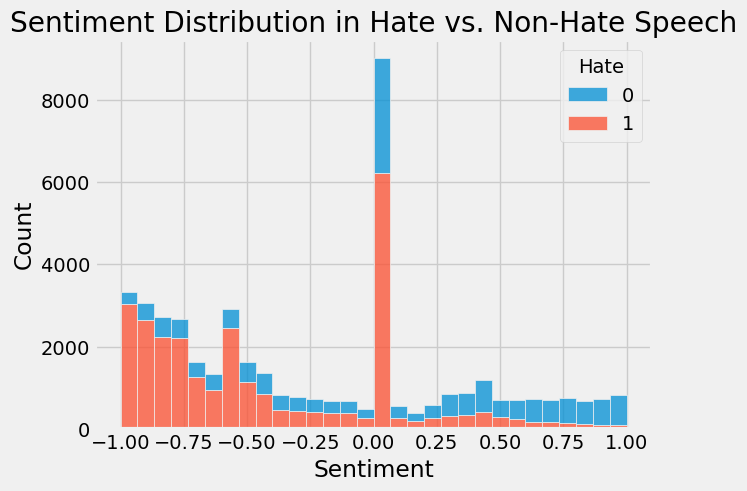

In [55]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

combined_df['Sentiment'] = combined_df['CleanedText'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualizing sentiment distribution for hate and non-hate speech
sns.histplot(combined_df, x='Sentiment', hue='Hate', multiple='stack', bins=30)
plt.title('Sentiment Distribution in Hate vs. Non-Hate Speech')
plt.show()

C:\Users\MIHIR_KOSREKAR\AppData\Local\Temp\ipykernel_14796\4174484298.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hate_trend = combined_df[combined_df['Hate'] == 1].resample('M').size()
C:\Users\MIHIR_KOSREKAR\AppData\Local\Temp\ipykernel_14796\4174484298.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  non_hate_trend = combined_df[combined_df['Hate'] == 0].resample('M').size()


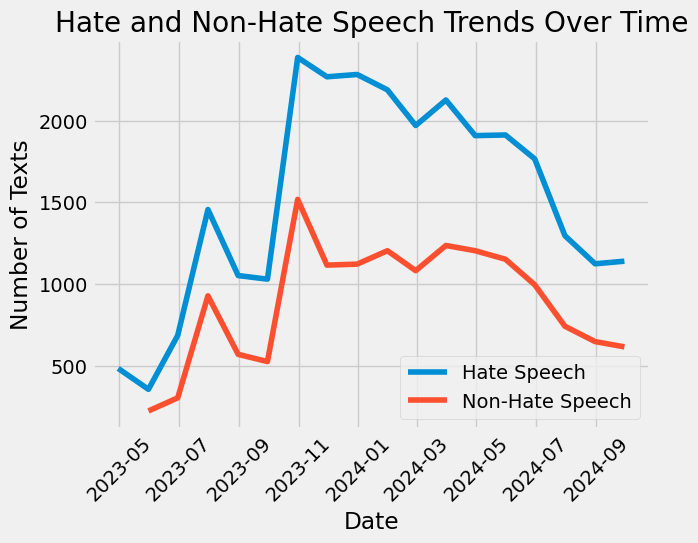

In [56]:
combined_df.set_index('Date', inplace=True)

hate_trend = combined_df[combined_df['Hate'] == 1].resample('M').size()
non_hate_trend = combined_df[combined_df['Hate'] == 0].resample('M').size()

hate_trend_filtered = hate_trend[:'2024-09']
non_hate_trend_filtered = non_hate_trend[:'2024-09']
plt.plot(hate_trend_filtered, label='Hate Speech')
plt.plot(non_hate_trend_filtered, label='Non-Hate Speech')
plt.title('Hate and Non-Hate Speech Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Texts')
plt.xticks(rotation=45)
plt.legend()
plt.show()


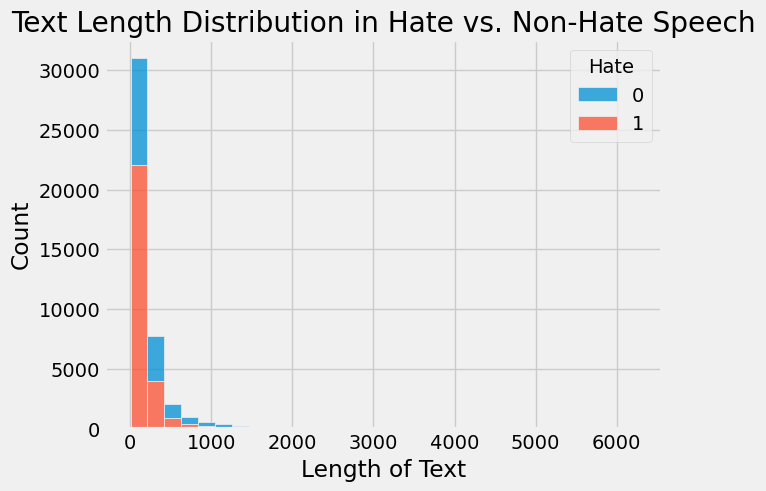

In [57]:
sns.histplot(combined_df, x='lenText', hue='Hate', multiple='stack', bins=30)
plt.title('Text Length Distribution in Hate vs. Non-Hate Speech')
plt.xlabel('Length of Text')
plt.show()

In [59]:
combined_df.to_csv("final_ds.csv")